In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from random import shuffle
from collections import Counter


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Read dataset
df = pd.read_csv('datasetwithoutexploit.csv')

In [4]:
# Groupement des classes
attack_group = {
    'Infilteration': 'Web attack', 
    'Fuzzers': 'Web attack',
    'Generic': 'Web attack',
    'injection': 'Web attack', 
    'Analysis': 'Web attack',
    'xss': 'Web attack',
    'Benign': 'BENIGN',
    'backdoor': 'BACKDOOR', 
    'scanning': 'SCANNING',
    'mitm': 'MITM', 
    'dos': 'DOS', 
    'ddos': 'DDOS', 
    'bruteforce': 'BRUTEFORCE', 
    'Theft': 'THEFT', 
    'Reconnaissance': 'RECON',
    'Shellcode': 'SHELLCODE',
    'ransomware': 'RANSOMWARE',
    'Bot': 'BOT'
}

# Création d'une colonne Attack_Category
df['Attack_Category'] = df['Attack'].map(lambda x: attack_group[x])
print(df['Attack_Category'].value_counts())
print(df.Label.value_counts())
print(df.Attack_Category.value_counts())
print(df.Attack.value_counts())

# Réorganisation des colonnes
cols = list(df)
cols.insert(43, cols.pop(cols.index('Attack')))
df = df.loc[:, cols]

# Séparation des données
X = df.drop(['Label', 'Attack', 'Attack_Category'], axis=1).values
y = df['Label'].values

# Comptage des labels
counter = Counter(y)
print(counter)


Attack_Category
BENIGN        41002
Web attack    14667
DDOS           2506
SCANNING       2500
RECON          2498
DOS            2497
RANSOMWARE     2493
BOT            2489
BRUTEFORCE     2485
BACKDOOR       2485
MITM           2471
THEFT          2431
SHELLCODE      1427
Name: count, dtype: int64
Label
0    41002
1    40949
Name: count, dtype: int64
Attack_Category
BENIGN        41002
Web attack    14667
DDOS           2506
SCANNING       2500
RECON          2498
DOS            2497
RANSOMWARE     2493
BOT            2489
BRUTEFORCE     2485
BACKDOOR       2485
MITM           2471
THEFT          2431
SHELLCODE      1427
Name: count, dtype: int64
Attack
Benign            41002
ddos               2506
scanning           2500
Reconnaissance     2498
dos                2497
ransomware         2493
Infilteration      2491
Fuzzers            2490
Bot                2489
Generic            2487
backdoor           2485
bruteforce         2485
mitm               2471
xss                2457

In [5]:
# Définir les paramètres à tester
param_grid = {'C': [0.1, 1, 10, 50, 100]}

# Création du modèle
model = SVC()

# Création de la recherche sur grille
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Exécution de la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_model = grid_search.best_estimator_
print(f"Meilleur hyperparamètre C: {grid_search.best_params_}")

# Entraînement du meilleur modèle sur l'ensemble des données d'entraînement
best_model.fit(X_train, y_train)

# Évaluation du modèle sur les données de test
score = best_model.score(X_test, y_test)
print(f"Score sur l'ensemble de test: {score}")


Meilleur hyperparamètre C: {'C': 100}


EPOCH (1/10) - Score train: 0.9985814521049421
EPOCH (2/10) - Score train: 0.9985814521049421
EPOCH (3/10) - Score train: 0.998581452104942
EPOCH (4/10) - Score train: 0.9985814521049421
EPOCH (5/10) - Score train: 0.9985814521049423
EPOCH (6/10) - Score train: 0.9985814521049421
EPOCH (7/10) - Score train: 0.9985814521049423
EPOCH (8/10) - Score train: 0.9985814521049421
EPOCH (9/10) - Score train: 0.9985814521049422
EPOCH (10/10) - Score train: 0.998581452104942


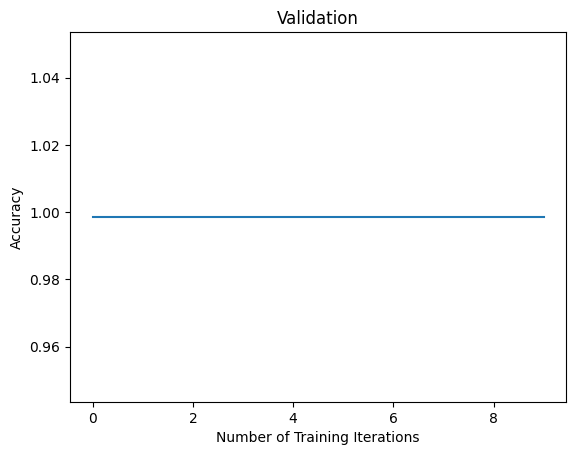

Score : 0.9985967909218474
Training time: 1692.3655288219452
Prediction time: 6.795001745223999
SVM Accuracy: 0.9985967909218474
SVM Precision: 0.9985973932455473
SVM Recall: 0.9985967909218474
SVM F1-Score: 0.9985967910158595
Error Score: 0.0014032090781526119


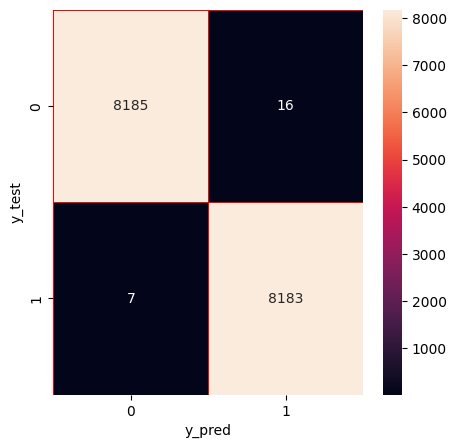

In [10]:
# Initialisation des paramètres d'entraînement
epochs = 10
val_score = []
val_score_t = []

# Entraînement par époques
data_train = pd.DataFrame(X_train)
data_train["label"] = y_train

start = time.time()
for i in range(epochs):
    shuffle(data_train.values)  # Mélange des données
    X_train_shuffled = data_train.iloc[:, :-1]
    y_train_shuffled = data_train.iloc[:, -1]
    
    for batch in range(1, 5):  # Simulation de l'entraînement par lots
        best_model.fit(X_train_shuffled, y_train_shuffled)
        score1 = best_model.score(X_train_shuffled, y_train_shuffled)
        val_score.append(score1)
        
    score = np.average(val_score)
    print(f"EPOCH ({i+1}/{epochs}) - Score train: {score}")
    val_score_t.append(score)
end = time.time()
training_time = end - start

# Visualisation des scores d'entraînement
plt.plot(val_score_t)
plt.title('Validation')
plt.ylabel('Accuracy')
plt.xlabel('Number of Training Iterations')
plt.show()

# Évaluation sur les données de test
start = time.time()
y_predict = best_model.predict(X_test)
score = best_model.score(X_test, y_test)
end = time.time()
predict_time = end - start

print("Score :", score)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')
print('Training time: ' + str(training_time))
print('Prediction time: ' + str(predict_time))
print("SVM Accuracy: {}".format(accuracy_score(y_test, y_predict)))
print('SVM Precision: ' + str(precision))
print('SVM Recall: ' + str(recall))
print('SVM F1-Score: ' + str(fscore))
print("Error Score: {}".format(1 - accuracy_score(y_test, y_predict)))

# Matrice de confusion
cm = confusion_matrix(y_test, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.show()
